### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

### Defining Parameters

In [2]:
# Set the initial conditions
q0 = np.pi/4   # initial position
p0 = 0         # initial momentum

L = 1           # Length of the pendulum
m = 1           # Mass of the pendulum
theta = 0       # Angle
g = 9.81        # Acceleration of gravity

# Set the simulation parameters
dt_leap = 0.01      # stepsize
dt_euler = 0.01
t_max = 10.0   # maximum simulation time
m = 1

### Hamiltonian dynamics for pendulum

In [3]:
def hamiltonian_dynamics(t, x): # for pendulum (996) and (997) in optimization
    return np.array([x[1]/(m*L^2), -m*g*L*np.sin(x[0])])

def gradient_potenital_energy(q): 
    return m*g*L*np.sin(q)

#### Leapfrog method

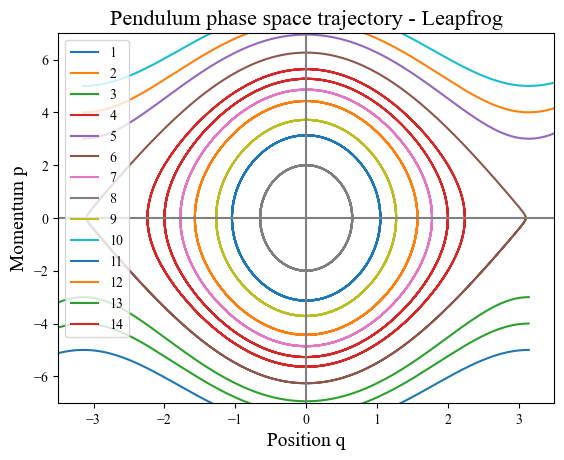

In [4]:
# Define the Leapfrog integrator
def leapfrog(q, p, dt):
    p_half = p - 0.5*dt*gradient_potenital_energy(q)
    q_next = q + dt*p_half
    p_next = p_half - 0.5*dt*gradient_potenital_energy(q_next)
    return q_next, p_next

def generate_trajectory(q0, p0):
    # Initialize the trajectory arrays
    t_leapfrog = np.arange(0, t_max, dt_leap)
    q_leapfrog = np.zeros_like(t_leapfrog)
    p_leapfrog = np.zeros_like(t_leapfrog)

    # Set the initial values
    q_leapfrog[0] = q0
    p_leapfrog[0] = p0

    # Run the simulation using the Leapfrog integrator
    for i in range(1, len(t_leapfrog)):
        q_leapfrog[i], p_leapfrog[i] = leapfrog(q_leapfrog[i-1], p_leapfrog[i-1], dt_leap)

    return q_leapfrog, p_leapfrog

init_conditions = [[np.pi/3, 0], [np.pi/2, 0], [np.pi, -3],  [2, 0], [-np.pi, 3], [3.1, 0], [np.pi/2, 2], [0, 2], [np.pi/3, 2], [-np.pi, 5], [np.pi, -5], [-np.pi, 4], [np.pi, -4], [2, -2]]
q_leapfrog = []
p_leapfrog = []
legend = []

for i in range(len(init_conditions)):
    q, p = generate_trajectory(init_conditions[i][0], init_conditions[i][1])
    q_leapfrog.append(q)
    p_leapfrog.append(p)

# Plot the trajectory in phase space
for i in range(len(q_leapfrog)):
    plt.plot(q_leapfrog[i], p_leapfrog[i])
    legend.append(str(i+1))

plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.xlim((-3.5, 3.5))
plt.ylim((-7, 7))
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
plt.legend(legend, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Pendulum phase space trajectory - Leapfrog', fontsize=16)
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_leapfrog.eps", format ="eps")
plt.show()

#### Explicit Euler method

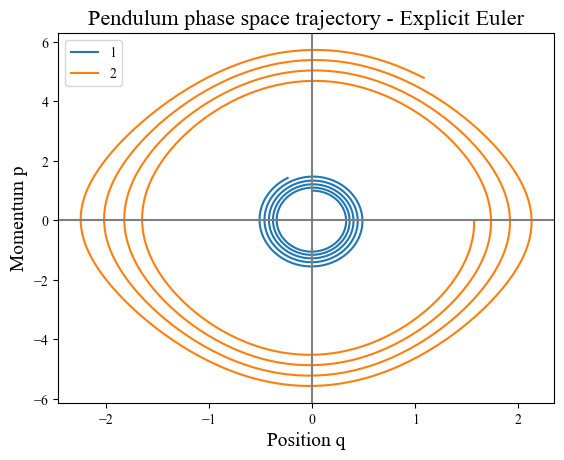

In [5]:
# Based on eurlers method in MCMC using hamiltonian dynamics
def explicit_euler(p, q, dt):
    p_next = p - dt * gradient_potenital_energy(q) # update position
    q_next = q + dt * p/m # update momentum
    return q_next, p_next

def generate_trajectory_euler(q0, p0):
    # Initialize the trajectory arrays
    t_euler = np.arange(0, t_max, dt_euler)
    q_euler = np.zeros_like(t_euler)
    p_euler = np.zeros_like(t_euler)

    # Set the initial values
    q_euler[0] = q0
    p_euler[0] = p0

    # Run the simulation using the Euler integrator
    for i in range(1, len(t_euler)):
        q_euler[i], p_euler[i] = explicit_euler(p_euler[i-1], q_euler[i-1], dt_euler)

    return q_euler, p_euler

#init_conditions_euler = [[np.pi/3, 0], [np.pi/2, 0], [np.pi, -3], [np.pi/2, 2], [0, 2], [2, 0], [-np.pi, 3], [3.1, 0]]
init_conditions_euler = [[0, 1], [np.pi/2, 0]]
q_euler = []
p_euler = []
legend_euler = []

for i in range(len(init_conditions_euler)):
    q, p = generate_trajectory_euler(init_conditions_euler[i][0], init_conditions_euler[i][1])
    q_euler.append(q)
    p_euler.append(p)

# Plot the trajectory in phase space
for i in range(len(q_euler)):
    plt.plot(q_euler[i], p_euler[i])
    legend_euler.append(str(i+1))

# Plot the trajectory in phase space
plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
plt.legend(legend_euler, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Pendulum phase space trajectory - Explicit Euler', fontsize=16)
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_expliciteuler.eps", format ="eps")
plt.show()

In [6]:
def psi(x, w, b):
    m = 1
    J = np.block([[np.zeros((m,m)), np.identity(m)],
              [-np.identity(m), np.zeros((m,m))]])
    return J*np.cos(w.T@x + b)@w.T

""" def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:, i])
    return np.array(psi_vector) """

def capital_psi(x, w, b, d, dim):
    psi_vector_symplectic = np.zeros((d, dim))
    for i in range(d):
        psi_element = psi(x, w[:, i], b[:, i])
        psi_vector_symplectic[i] = psi_element
    return psi_vector_symplectic.T

def phi(x, w, b, n, d, dim):
    phi = np.zeros((dim*n, d))
    for i in range(n):
        psi = capital_psi(x[:, i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, d, lam, n):
    phi_ = phi(x_vector, w, b, n, d, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(d))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

In [7]:
q_leapfrog_tot = np.concatenate(q_leapfrog)
p_leapfrog_tot = np.concatenate(p_leapfrog)

C:\Users\vilde\AppData\Local\Temp\ipykernel_4736\3354343101.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dho_trajectory.show()


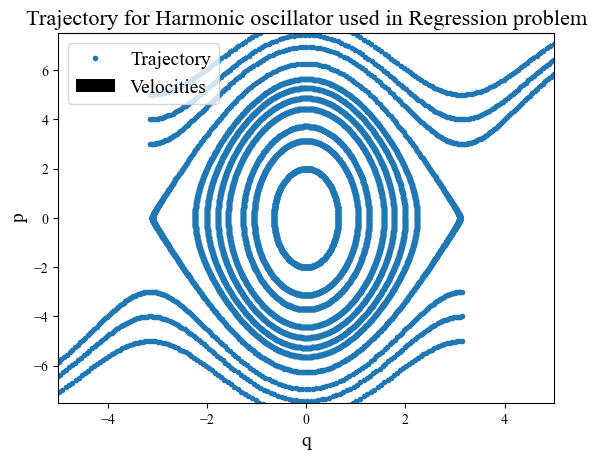

In [8]:
#x_train = np.array([q_leapfrog_tot[:100], p_leapfrog_tot[:100]])
x_train = np.array([q_leapfrog_tot, p_leapfrog_tot])
y_train = np.zeros_like(x_train)

time_series = np.arange(0, 100, dt_leap)

for i in range(len(x_train[0])):
    y_train[:, i] = hamiltonian_dynamics(0, x_train[:, i])
        
# Query only the length of the second dimension of x_train
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

# Plot resulting trajectory in the data set and belonging streamlines
fig_dho_trajectory = plt.figure(5)
plt.title('Trajectory for Harmonic oscillator used in Regression problem', fontsize=16)
plt.plot(x_train[0, :], x_train[1, :], '.', linewidth=1)
plt.quiver(x_train[0, :], x_train[1, :], y_train[0, :], y_train[1, :])
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Trajectory', 'Velocities'], frameon = True , prop ={'size': 14 } )
plt.xlim([-5, 5])
plt.ylim([-7.5, 7.5])
fig_dho_trajectory.show()
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_trajectory_lf.eps", format ="eps")

In [9]:
# _____________________ Regression _____________________

num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

sigma = 5
num_of_samples = 30
w = randn(dim_of_function, num_of_samples)/sigma
b = rand(1, num_of_samples)*2*np.pi

# Get alphas (coefficient vectors)
lambda_ = 0.1
alpha_array_rff = alpha_approx(x_train, y_train, dim_of_function, num_of_samples, lambda_, num_of_points)
phi_ = phi(x_train, w, b, num_of_points, num_of_samples, dim_of_function)

def learnt_model(t, x):
    func = capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff
    return func

def learnt_model2(t, x): return np.transpose(capital_psi(x, w, b, num_of_samples, dim_of_function) @ alpha_array_rff)

init_time = 0
end_time = 10
timespan = np.array([init_time, end_time])
init_condition = np.array(([2, -2]))
t = np.linspace(init_time, end_time, 500)

# Solve diff. equations using learnt model with solve_ivp
data_series = solve_ivp(learnt_model, timespan, init_condition, t_eval=t).y

C:\Users\vilde\AppData\Local\Temp\ipykernel_4736\647540614.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_ho_w_rff.show()


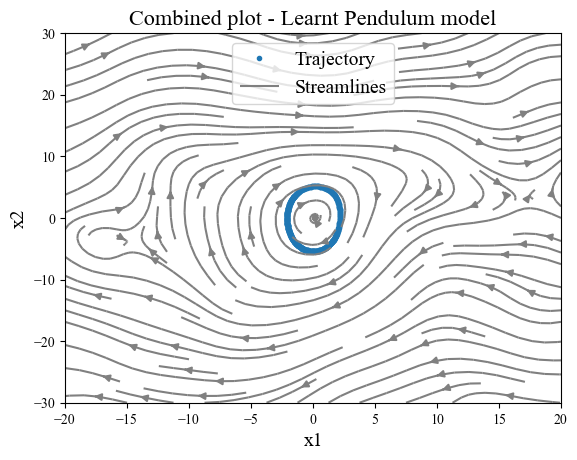

In [10]:
lower_bound_x1 = -20
upper_bound_x1 = 20
lower_bound_x2 = -30
upper_bound_x2 = 30

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i, j), value in np.ndenumerate(X1):
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i, j] = Y_prime[0]
    v_learnt[i, j] = Y_prime[1]

# Plot simulated trajectory and streamslices for learnt model
fig_ho_w_rff = plt.figure(6)
plt.title('Combined plot - Learnt Pendulum model', fontsize=16)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth = 1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Streamlines'], frameon = True , prop ={'size': 14 } )
fig_ho_w_rff.show()
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_learned_model_lf.eps", format ="eps")